In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tomarata = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/tomarataCombined_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
tomarata.head()

,Timestamp (UTC+12:00),Rain(mm),SoilTemp(c),SoilMoisture(%)
0,2019-05-26 04:00:00,0.0,15.229,35.790667
1,2019-05-26 04:15:00,0.0,15.200,33.602000
2,2019-05-26 04:30:00,0.0,15.200,33.602000
3,2019-05-26 04:45:00,0.0,15.200,33.602000
4,2019-05-26 05:00:00,0.0,15.200,33.605000


Resample Data to 15 minutes interval

In [3]:
tomarata.set_index('Timestamp (UTC+12:00)', inplace=True)

resampled_df = tomarata.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_11888\2416431346.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = tomarata.resample('H').agg({


Cross-correlation

In [4]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

max_lag = 30

def cross_correlation(x, y, max_lag):
    """Calculate cross-correlation between two signals."""
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    return lags, correlation

In [5]:
tomarata_daily = tomarata.resample('D').agg({'Rain(mm)': 'sum','SoilTemp(c)': 'mean','SoilMoisture(%)': 'mean'})

In [6]:
soil_moisture = tomarata_daily['SoilMoisture(%)'].values
rainfall = tomarata_daily['Rain(mm)'].values
soil_temp = tomarata_daily['SoilTemp(c)'].values

In [7]:
tomarata_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1935 entries, 2019-05-26 to 2024-09-10
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         1935 non-null   float64
 1   SoilTemp(c)      1935 non-null   float64
 2   SoilMoisture(%)  1935 non-null   float64
dtypes: float64(3)
memory usage: 60.5 KB


In [8]:
# Calculate 7-day rolling average for Rain(mm), SoilTemp(c), and SoilMoisture(%)
tomarata_daily['Rain_7d_avg'] = tomarata_daily['Rain(mm)'].rolling(window=7, min_periods=1).sum()
tomarata_daily['SoilTemp_7d_avg'] = tomarata_daily['SoilTemp(c)'].rolling(window=7, min_periods=1).mean()

# Calculate 30-day rolling average for the same columns
tomarata_daily['Rain_30d_avg'] = tomarata_daily['Rain(mm)'].rolling(window=30, min_periods=1).sum()
tomarata_daily['SoilTemp_30d_avg'] = tomarata_daily['SoilTemp(c)'].rolling(window=30, min_periods=1).mean()
tomarata_daily['SoilMoisture_30d_avg'] = tomarata_daily['SoilMoisture(%)'].rolling(window=30, min_periods=1).mean()
tomarata_daily.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%),Rain_7d_avg,SoilTemp_7d_avg,Rain_30d_avg,SoilTemp_30d_avg,SoilMoisture_30d_avg
Timestamp (UTC+12:00),,,,,,,,
2019-05-26,0.0,15.640363,33.292871,0.0,15.640363,0.0,15.640363,33.292871
2019-05-27,0.5,16.279167,32.989542,0.5,15.959765,0.5,15.959765,33.141206
2019-05-28,4.5,16.810417,32.907438,5.0,16.243315,5.0,16.243315,33.063283
2019-05-29,0.5,16.135417,33.399115,5.5,16.216341,5.5,16.216341,33.147241
2019-05-30,0.5,14.910417,33.581167,6.0,15.955156,6.0,15.955156,33.234026


In [9]:
rainfall_lags = [1, 3, 5, 7, 30,60]  
soil_temp_lags = [1, 3, 7, ] 

for i in rainfall_lags:
    tomarata_daily[f'Rainfall_lag_{i}'] = tomarata_daily['Rain(mm)'].shift(i)

for i in soil_temp_lags:
    tomarata_daily[f'SoilTemp_lag_{i}'] = tomarata_daily['SoilTemp(c)'].shift(i)

# Drop rows with NaN values in the lag features
tomarata_daily.dropna(inplace=True)

In [10]:
lag_size = 30
# Calculate cross-correlation for rainfall and soil temperature
lags_rain_temp, correlation_rain_temp = cross_correlation(rainfall, soil_temp, lag_size)
print("Cross-Correlation between Rainfall and Soil Temperature:")
print("Lags:", lags_rain_temp)
print("Correlation:", correlation_rain_temp)

Cross-Correlation between Rainfall and Soil Temperature:
Lags: [-1934 -1933 -1932 ...  1932  1933  1934]
Correlation: [ 0.          7.17451705 71.11343466 ... 23.46054375  0.
  0.        ]


In [11]:

# Calculate cross-correlation for rainfall and soil moisture
lags_rain_moist, correlation_rain_moist = cross_correlation(rainfall, soil_moisture, lag_size)
print("\nCross-Correlation between Rainfall and Soil Moisture:")
print("Lags:", lags_rain_moist)
print("Correlation:", correlation_rain_moist)


Cross-Correlation between Rainfall and Soil Moisture:
Lags: [-1934 -1933 -1932 ...  1932  1933  1934]
Correlation: [  0.          19.13846023 191.489366   ...  49.93930625   0.
   0.        ]


In [12]:
# Calculate cross-correlation for soil moisture and soil temperature
lags_moist_temp, correlation_moist_temp = cross_correlation(soil_moisture, soil_temp, lag_size)
print("\nCross-Correlation between Soil Moisture and Soil Temperature:")
print("Lags:", lags_moist_temp)
print("Correlation:", correlation_moist_temp)


Cross-Correlation between Soil Moisture and Soil Temperature:
Lags: [-1934 -1933 -1932 ...  1932  1933  1934]
Correlation: [ 477.72053857  909.02400011 1388.58582432 ... 1876.704763   1225.05836432
  598.66491129]


<Axes: >

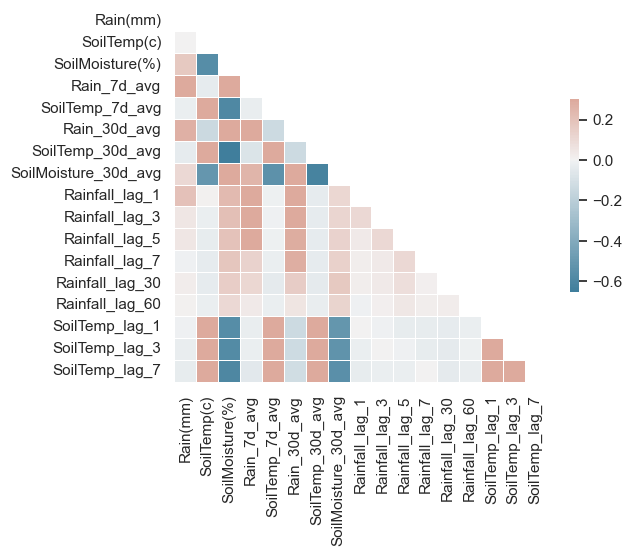

In [13]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = tomarata_daily.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Predictive Model

In [14]:
tomarata_daily.columns

Index(['Rain(mm)', 'SoilTemp(c)', 'SoilMoisture(%)', 'Rain_7d_avg',
       'SoilTemp_7d_avg', 'Rain_30d_avg', 'SoilTemp_30d_avg',
       'SoilMoisture_30d_avg', 'Rainfall_lag_1', 'Rainfall_lag_3',
       'Rainfall_lag_5', 'Rainfall_lag_7', 'Rainfall_lag_30',
       'Rainfall_lag_60', 'SoilTemp_lag_1', 'SoilTemp_lag_3',
       'SoilTemp_lag_7'],
      dtype='object')

In [15]:

X = tomarata_daily.drop(columns=['SoilMoisture(%)', 'SoilMoisture_30d_avg'])

y = tomarata_daily[['SoilMoisture(%)']]

X.dropna(inplace=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1875, 15)
y shape: (1875, 1)


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")


Random Forest Testing Set Metrics:
MAE: 1.8596218915253455
MSE: 7.580014914303687
RMSE: 2.7531826881454284
R2 Score: 0.9266375466505805


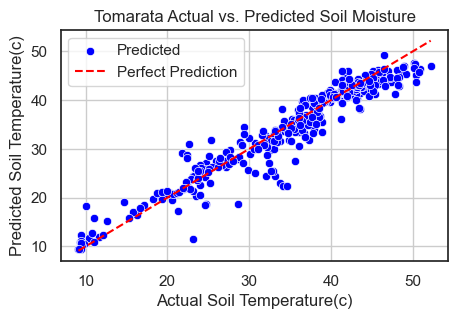

In [19]:
y_test_df = pd.DataFrame(y_test.reset_index(drop=True), columns=['SoilMoisture(%)'])
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Tomarata Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Temperature(c)')
plt.ylabel('Predicted Soil Temperature(c)')
plt.legend()
plt.grid()
plt.show()

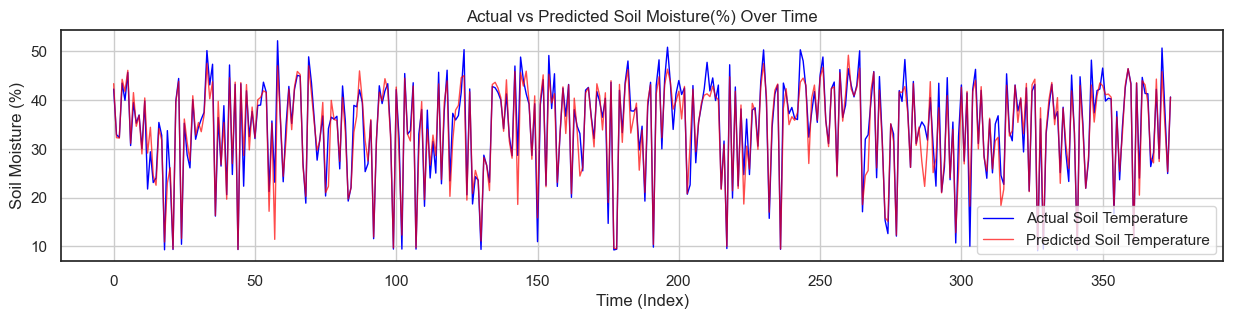

In [20]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(15, 3))
plt.plot(results_df.index, results_df['SoilMoisture(%)'], label='Actual Soil Temperature', color='blue', linewidth=1)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Soil Temperature', color='red',  linewidth=1, alpha=0.7)

# Customize plot labels and legend
plt.title('Actual vs Predicted Soil Moisture(%) Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

print("Actual index:", tomarata_daily.index[-len(y_test):])
print("Predictions index:", results_df.index)

print("Length of actual values:", len(tomarata_daily['SoilMoisture(%)']))
print("Length of predictions:", len(results_df['Predicted']))


Actual index: DatetimeIndex(['2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
               '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09',
               '2023-09-10', '2023-09-11',
               ...
               '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-04',
               '2024-09-05', '2024-09-06', '2024-09-07', '2024-09-08',
               '2024-09-09', '2024-09-10'],
              dtype='datetime64[ns]', name='Timestamp (UTC+12:00)', length=375, freq='D')
Predictions index: RangeIndex(start=0, stop=375, step=1)
Length of actual values: 1875
Length of predictions: 375


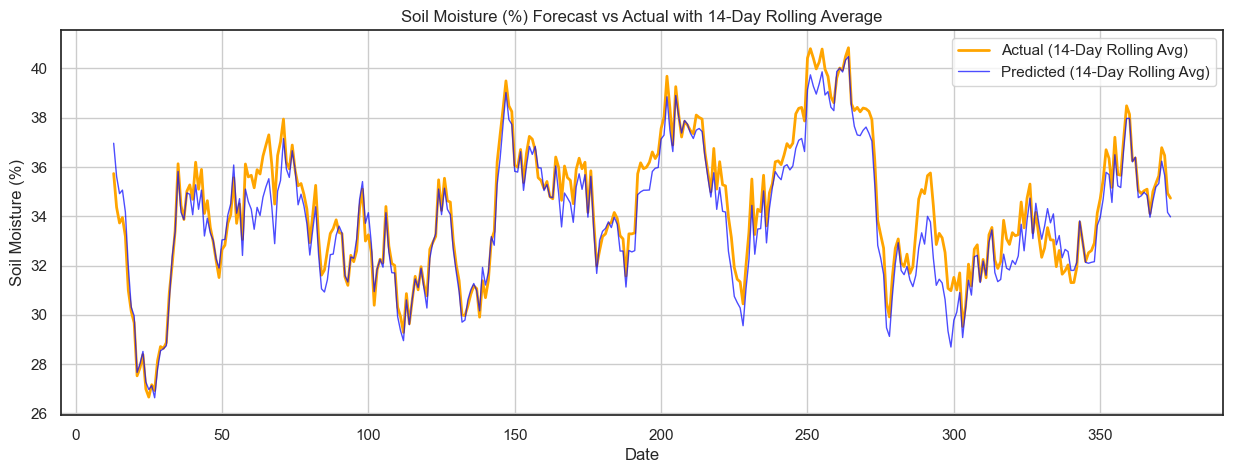

In [22]:
actual_rolling = results_df['SoilMoisture(%)'].rolling(window=14).mean()
predicted_rolling = results_df['Predicted'].rolling(window=14).mean()

plt.figure(figsize=(15, 5))
# plt.plot(ararimu_daily.index, ararimu_daily['SoilMoisture(%)'], label='Actual Soil Moisture (%)')
plt.plot(results_df.index, actual_rolling, color='orange', label='Actual (14-Day Rolling Avg)', linewidth=2)
plt.plot(results_df.index, predicted_rolling, color='blue', label='Predicted (14-Day Rolling Avg)', linewidth=1, alpha=0.7)

# Customize plot
plt.title('Soil Moisture (%) Forecast vs Actual with 14-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.grid(True)
plt.show()


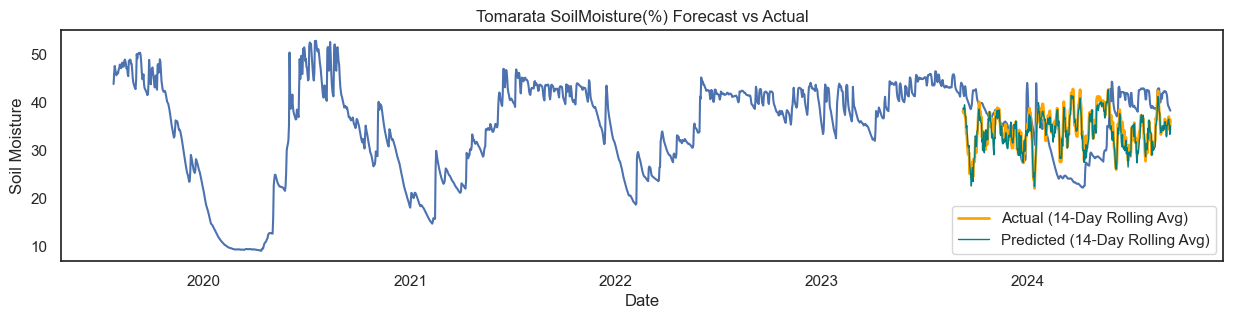

In [24]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(rf_predictions, columns=['Predicted'])
actual_rolling = results_df['SoilMoisture(%)'].rolling(window=7).mean()
predicted_rolling = results_df['Predicted'].rolling(window=7).mean()

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = tomarata_daily.index[-len(y_test):] 

plt.figure(figsize=(15, 3))
plt.plot(tomarata_daily['SoilMoisture(%)'])
plt.plot(results_df.index, actual_rolling, color='orange', label='Actual (14-Day Rolling Avg)', linewidth=2)
plt.plot(results_df.index, predicted_rolling, color='teal', label='Predicted (14-Day Rolling Avg)', linewidth=1)

plt.title('Tomarata SoilMoisture(%) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

